In [5]:
import numpy as np
import matplotlib.pyplot as plt
from utils.cinematica import *
from utils.player import MotorsController

In [31]:
def get_route_positions(xi, zi, alphai, xf, zf, alphaf, divisions=20, plot=False):
    ri, thetai, oi = get_r_theta_o(xi, zi, alphai)
    rf, thetaf, of = get_r_theta_o(xf, zf, alphaf)

    deltaR = rf - ri
    deltaTheta = thetaf - thetai
    deltaO = of - oi

    x2i, z2i = get_pos_punta(xi, zi, alphai*pi/180)
    x_a, z_a, alpha_a = xi, zi, alphai

    x2f, z2f = get_pos_punta(xf, zf, alphaf*pi/180)

    dist = 0
    d = []
    x_points = []
    z_points = []
    alpha_points = []
    x2_points = []
    z2_points = []
    for n in range(divisions+1):
        xn, zn, alphan = get_x_z_alpha(ri + n*deltaR/divisions, thetai + n*deltaTheta/divisions, oi + n*deltaO/divisions)
        #print(ri + n*deltaR/N, thetai + n*deltaTheta/N, oi + n*deltaO/N)
        #print(get_r_theta_o(xn, zn, alphan))
        #print(alphan)
        x_points.append(round(xn,3))
        z_points.append(round(zn,3))
        alpha_points.append(round(alphan,3))
        if plot:
            x2, z2 = get_pos_punta(xn, zn, alphan*pi/180)
            x2_points.append(x2)
            z2_points.append(z2)
        dist += sqrt((xn - x_a)**2 + (zn - z_a)**2 + (alphan - alpha_a)**2)
        d.append(dist)
        x_a, z_a, alpha_a = xn, zn, alphan

    return x_points, z_points, alpha_points, d

def max_dist_rec(acc, dec, T):
    d_acc = (acc/2) * ((dec*T)/(acc+dec))**2
    d_dec = acc*(dec*T)/(acc+dec) * (T-(dec*T)/(acc+dec)) / 2
    dist_max = d_acc + d_dec
    return dist_max

def plan_speed_curve(d, acceleration, deceleration, T):
    speed = (acceleration*deceleration*T - sqrt(acceleration*deceleration*(acceleration*deceleration*T**2 - 2*acceleration*d - 2*deceleration*d))) / (acceleration+deceleration)
    t_acc = speed / acceleration
    t_dec = T - speed / deceleration
    return speed, t_acc, t_dec

def plan_temps_according_to_speed(distances, vel, t_acc, t_dec, acc, dec):
    d_t_acc = acc * t_acc**2 / 2
    d_t_dec = d_t_acc + vel * (t_dec - t_acc)
    temps = []
    for d_sum in distances:
        if d_sum < d_t_acc:
            temps.append(sqrt(2*d_sum/acc))
        elif d_sum < d_t_dec:
            temps.append((d_sum - d_t_acc)/vel + t_acc)
        else:
            a = dec / 2
            b = -(vel + (2*t_dec*dec)/2)
            c = d_sum - d_t_dec + vel*t_dec + (dec*t_dec**2)/2
            t = (-b - sqrt(round(b**2 - 4*a*c,3)))/(2*a)
            temps.append(t)
    return temps

def x_mm_to_units(mm):
    return int(mm * 1000 / 8 )

def z_mm_to_units(mm):
    return int(mm * 1000 / 8 )

def alpha_angle_to_units(angle):
    return int(angle * 10000 / 360)

def plan_route(x_points, z_points, alpha_points, temps):
    points = {'x': [], 'z': [], 'alpha': [], 't': []}

    for i in range(len(x_points) - 1):
        x = x_mm_to_units(x_points[i])            
        z = z_mm_to_units(z_points[i])
        alpha = alpha_angle_to_units(alpha_points[i])
        t = temps[i]

        points['x'].append(x)
        points['z'].append(z)
        points['alpha'].append(alpha)
        points['t'].append(t)

    return points
        
def get_route(initial_state, final_state, acc=20, dec=20, T=None):
    x_points, z_points, alpha_points, d = get_route_positions(*initial_state.cart_coords(), *final_state.cart_coords(), divisions=12, plot=False)
    if not T:
        T = 0.1
        while True:
            if not max_dist_rec(acc, dec, T) < d[-1]:
                break
            T += 0.1
        T = T*2
    else:
        if max_dist_rec(acc, dec, T) < d[-1]:
            print(f'Impossible to achieve such position with given acceleration and deceleration. {d[-1]} > {max_dist_rec(acc, dec, T)}')
            return None
    vel, t_acc, t_dec = plan_speed_curve(d[-1], acc, dec, T)
    temps = plan_temps_according_to_speed(d, vel, t_acc, t_dec, acc, dec)
    route = plan_route(x_points, z_points, alpha_points, temps)
    return route

In [38]:
stateA = State(15,45,0,0)
stateB = State(9,41,0.5,10)

r = get_route(stateA, stateB, acc=20, dec=20, T=3)

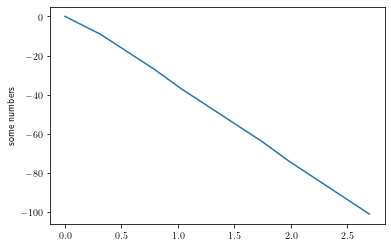

In [39]:
plt.plot(r['t'], r['alpha'])
plt.ylabel('some numbers')
plt.show()

In [34]:
r

{'x': [6250, 6312, 6375, 6438, 6501, 6564, 6628, 6691, 6755, 6819, 6883, 6948],
 'z': [17375,
  17410,
  17446,
  17480,
  17514,
  17547,
  17579,
  17610,
  17641,
  17671,
  17701,
  17729],
 'alpha': [0, -9, -18, -27, -37, -46, -55, -64, -74, -83, -92, -101],
 't': [2.522123978500469e-08,
  0.31009307616641557,
  0.5505647792032898,
  0.7905606627309493,
  1.030089337762006,
  1.2691601354008568,
  1.507783255877242,
  1.7459699570598262,
  1.9837327952310435,
  2.2210859358770407,
  2.458045559513349,
  2.694630398374661]}